In [111]:
%matplotlib inline
import os
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training

print(tf.__version__)

2.11.0


In [112]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

20000


In [113]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


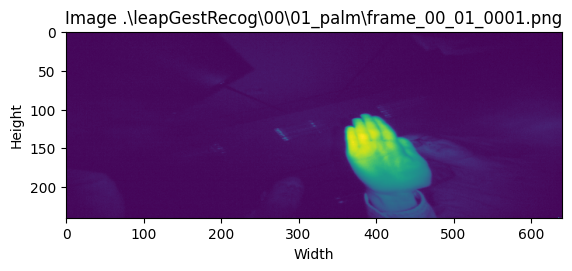

In [114]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [115]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster

  X.append(img)
  
  # Processing label in image path
  category = path.split("\\")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
1 .\leapGestRecog\00\01_palm\frame_00_01_0001.png


In [116]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [117]:
X_train.shape

(14000, 120, 320, 1)

In [119]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [120]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [121]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [122]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 685s - loss: 0.7543 - accuracy: 0.9346 - val_loss: 0.0036 - val_accuracy: 0.9997 - 685s/epoch - 3s/step
Epoch 2/5
219/219 - 680s - loss: 0.0039 - accuracy: 0.9993 - val_loss: 2.9748e-04 - val_accuracy: 1.0000 - 680s/epoch - 3s/step
Epoch 3/5
219/219 - 689s - loss: 5.1458e-04 - accuracy: 0.9999 - val_loss: 5.3063e-05 - val_accuracy: 1.0000 - 689s/epoch - 3s/step
Epoch 4/5
219/219 - 664s - loss: 1.8860e-05 - accuracy: 1.0000 - val_loss: 2.6613e-05 - val_accuracy: 1.0000 - 664s/epoch - 3s/step
Epoch 5/5
219/219 - 683s - loss: 7.4530e-06 - accuracy: 1.0000 - val_loss: 1.8574e-05 - val_accuracy: 1.0000 - 683s/epoch - 3s/step


In [123]:
# Save entire model to a HDF5 file
model.save('handrecognition_model.h5')

In [124]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 76s 405ms/step - loss: 1.8574e-05 - accuracy: 1.0000
Test accuracy: 100.00%


In [125]:
predictions = model.predict(X_test) # Make predictions towards the test set

188/188 [==============================] - 75s 399ms/step


In [126]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(4, 4)

In [127]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title based on good prediction or not
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

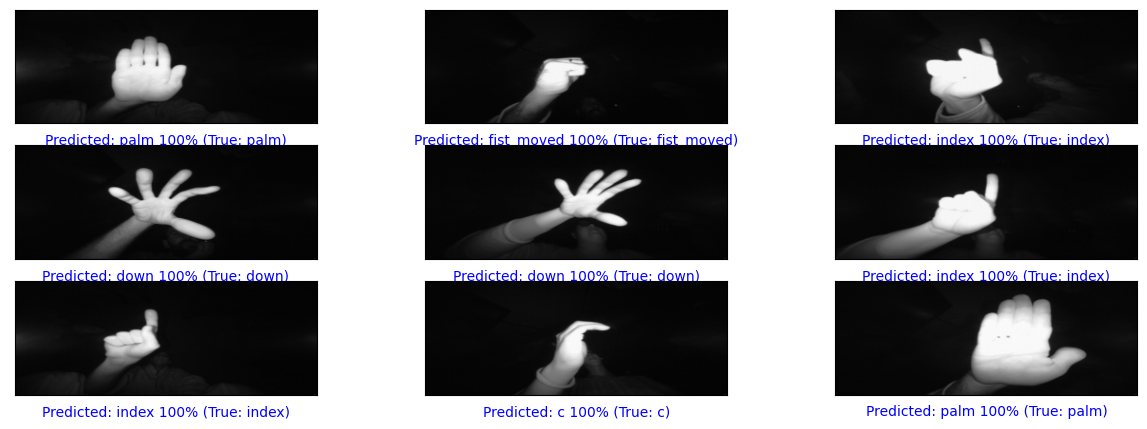

In [128]:
validate_9_images(predictions, y_test, X_test)

In [129]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [130]:
# Recreate the exact same model, including weights and optimizer.
model = keras.models.load_model('handrecognition_model.h5')
model.summary()

# To use the pre-trained model, just load it and skip to the next session.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 116, 316, 32)      832       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 58, 158, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 56, 156, 64)       18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 28, 78, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 76, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 13, 38, 64)      